In [0]:
import librosa
import os
import random
import numpy as np
import csv
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from google.colab import drive

In [3]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
!ls /content/gdrive/My\ Drive/End-to-end_accented
os.chdir('/content/gdrive/My Drive/End-to-end_accented')

Australia_mfcc.csv  CNN_model	      extra_code  India_mfcc.csv
Canada_mfcc.csv     England_mfcc.csv  GRU_model   US_mfcc.csv


In [0]:
def csv2data(Australia, Canada, England, India, US):
  Australia_data = np.loadtxt(Australia, delimiter = ",", dtype = np.int32)
  Canada_data = np.loadtxt(Canada, delimiter = ",", dtype = np.int32)
  England_data = np.loadtxt(England, delimiter = ",", dtype = np.int32)
  India_data = np.loadtxt(India, delimiter = ",", dtype = np.int32)
  US_data = np.loadtxt(US, delimiter = ",", dtype = np.int32)

  Australia_num=1220000
  Canada_num=1280000
  England_num=1150000
  India_num=1225000
  US_num=1215000

  Australia_train_num=Australia_num-(Australia_num//5)*2 #732000
  Australia_val_num=Australia_num//5 #244000
  Australia_test_num=Australia_num//5 #244000

  Canada_train_num=Canada_num-(Canada_num//5)*2 #768000
  Canada_val_num=Canada_num//5 #256000
  Canada_test_num=Canada_num//5 #256000

  England_train_num=England_num-(England_num//5)*2 #690000
  England_val_num=England_num//5 #230000
  England_test_num=England_num//5 #230000

  India_train_num=India_num-(India_num//5)*2 #735000
  India_val_num=India_num//5 #245000
  India_test_num=India_num//5 #245000

  US_train_num=US_num-(US_num//5)*2 #729000
  US_val_num=US_num//5 #243000
  US_test_num=US_num//5 #243000
  
  Australia_train = Australia_data[:Australia_train_num,:-1] #732000
  Australia_val = Australia_data[Australia_train_num:Australia_train_num+Australia_val_num,:-1]
  Australia_test = Australia_data[Australia_train_num+Australia_val_num:Australia_train_num+Australia_val_num+Australia_test_num,:-1]

  Canada_train = Canada_data[:Canada_train_num,:-1] #768000
  Canada_val = Canada_data[Canada_train_num:Canada_train_num+Canada_val_num,:-1]
  Canada_test = Canada_data[Canada_train_num+Canada_val_num:Canada_train_num+Canada_val_num+Canada_test_num,:-1]

  England_train = England_data[:England_train_num,:-1] #690000
  England_val = England_data[England_train_num:England_train_num+England_val_num,:-1]
  England_test = England_data[England_train_num+England_val_num:England_train_num+England_val_num+England_test_num,:-1]

  India_train = India_data[:India_train_num,:-1] #735000
  India_val = India_data[India_train_num:India_train_num+India_val_num,:-1]
  India_test = India_data[India_train_num+India_val_num:India_train_num+India_val_num+India_test_num,:-1]

  US_train = US_data[:US_train_num,:-1] #729000
  US_val = US_data[US_train_num:US_train_num+US_val_num,:-1]
  US_test = US_data[US_train_num+US_val_num:US_train_num+US_val_num+US_test_num,:-1]

  train_data = np.vstack([Australia_train,Canada_train,England_train,India_train,US_train])
  val_data = np.vstack([Australia_val,Canada_val,England_val,India_val,US_val])
  test_data = np.vstack([Australia_test,Canada_test,England_test,India_test,US_test])

  return train_data, val_data, test_data

In [0]:
def csv2label(Australia, Canada, England, India, US):
  Australia_data = np.loadtxt(Australia, delimiter = ",", dtype = np.int32)
  Canada_data = np.loadtxt(Canada, delimiter = ",", dtype = np.int32)
  England_data = np.loadtxt(England, delimiter = ",", dtype = np.int32)
  India_data = np.loadtxt(India, delimiter = ",", dtype = np.int32)
  US_data = np.loadtxt(US, delimiter = ",", dtype = np.int32)

  Australia_num=1220000
  Canada_num=1280000
  England_num=1150000
  India_num=1225000
  US_num=1215000

  Australia_train_num=Australia_num-(Australia_num//5)*2 #732000
  Australia_val_num=Australia_num//5 #244000
  Australia_test_num=Australia_num//5 #244000

  Canada_train_num=Canada_num-(Canada_num//5)*2 #768000
  Canada_val_num=Canada_num//5 #256000
  Canada_test_num=Canada_num//5 #256000

  England_train_num=England_num-(England_num//5)*2 #690000
  England_val_num=England_num//5 #230000
  England_test_num=England_num//5 #230000

  India_train_num=India_num-(India_num//5)*2 #735000
  India_val_num=India_num//5 #245000
  India_test_num=India_num//5 #245000

  US_train_num=US_num-(US_num//5)*2 #729000
  US_val_num=US_num//5 #243000
  US_test_num=US_num//5 #243000

  divider=400
  
  Australia_train = Australia_data[:Australia_train_num//divider,-1] #1830
  Australia_val = Australia_data[Australia_train_num:Australia_train_num+Australia_val_num//divider,-1] #610
  Australia_test = Australia_data[Australia_train_num+Australia_val_num:Australia_train_num+Australia_val_num+Australia_test_num//divider,-1] #610
  
  Canada_train = Canada_data[:Canada_train_num//divider,-1] #1920
  Canada_val = Canada_data[Canada_train_num:Canada_train_num+Canada_val_num//divider,-1] #640
  Canada_test = Canada_data[Canada_train_num+Canada_val_num:Canada_train_num+Canada_val_num+Canada_test_num//divider,-1] #640

  England_train = England_data[:England_train_num//divider,-1] #1725
  England_val = England_data[England_train_num:England_train_num+England_val_num//divider,-1] #575
  England_test = England_data[England_train_num+England_val_num:England_train_num+England_val_num+England_test_num//divider,-1] #575

  India_train = India_data[:India_train_num//divider,-1] #1837
  India_val = India_data[India_train_num:India_train_num+India_val_num//divider,-1] #612
  India_test = India_data[India_train_num+India_val_num:India_train_num+India_val_num+India_test_num//divider,-1] #612

  US_train = US_data[:(US_train_num//divider)+1,-1] #1822
  US_val = US_data[US_train_num:US_train_num+(US_val_num//divider)+1,-1] #607
  US_test = US_data[US_train_num+US_val_num:US_train_num+US_val_num+(US_test_num//divider)+1,-1] #607

  train_label = np.concatenate((Australia_train,Canada_train,England_train,India_train,US_train),axis=0)
  val_label = np.concatenate((Australia_val,Canada_val,England_val,India_val,US_val),axis=0)
  test_label = np.concatenate((Australia_test,Canada_test,England_test,India_test,US_test),axis=0)

  return train_label, val_label, test_label

In [0]:
class Accent_dataset(Dataset): 
  def __init__(self, csv2data, csv2label):

    self.x_data=csv2data[:,:]
    self.y_data=csv2label[:]

    self.x_data = self.x_data.reshape(-1, 13, 20, 20)
    self.y_data = self.y_data.reshape(-1,)

    self.x_data = torch.cuda.FloatTensor(self.x_data)
    self.y_data = torch.cuda.LongTensor(self.y_data)

    print("=== Dataset Download Complete !!")
    print("X shape:",self.x_data.shape)
    print("Y shape:",self.y_data.shape)

    self.len = len(self.x_data)

  def __getitem__(self, index): 
    return self.x_data[index], self.y_data[index] 

  def __len__(self): 
    return self.len

In [8]:
train, val, test = csv2data('Australia_mfcc.csv','Canada_mfcc.csv','England_mfcc.csv','India_mfcc.csv','US_mfcc.csv')
train_label, val_label, test_label = csv2label('Australia_mfcc.csv','Canada_mfcc.csv','England_mfcc.csv','India_mfcc.csv','US_mfcc.csv')

train_dataset = Accent_dataset(train,train_label)
val_dataset = Accent_dataset(val,val_label)  
test_dataset = Accent_dataset(test,test_label)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=True)

=== Dataset Download Complete !!
X shape: torch.Size([9135, 13, 20, 20])
Y shape: torch.Size([9135])
=== Dataset Download Complete !!
X shape: torch.Size([3045, 13, 20, 20])
Y shape: torch.Size([3045])
=== Dataset Download Complete !!
X shape: torch.Size([3045, 13, 20, 20])
Y shape: torch.Size([3045])


In [9]:
#device setting

device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print(device)

cuda


In [0]:
#parameters

num_epochs=150
learning_rate=0.00001
batch_size=64

In [11]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        # input channels, output channels (The number of kernels), kernel size, stride, padding
        self.conv1 = nn.Conv2d(13, 16, 3, 1, 1) #16 20*20
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2) # kernel size, stride, padding = 0 (default) #16 10*10

        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1) #32 10*10
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2) #32 5*5

        self.conv3 = nn.Conv2d(32, 64, 3, 1, 1) #64 5*5
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2) #64 2x2

        self.fc1 = nn.Linear(256, 256) # input features, output features
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 5)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

cnn_model=CNN_model().to(device)
print(cnn_model)

CNN_model(
  (conv1): Conv2d(13, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=5, 

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=learning_rate)

Training start
Epoch:    0/150 | Train loss: 0.015986
Epoch:    0/150 | Validation loss: 1.604955
[Validation set] ERR: 0.778325 | ACC: 0.221675 (675 / 3045)

Epoch:   10/150 | Train loss: 0.009952
Epoch:   10/150 | Validation loss: 1.053464
[Validation set] ERR: 0.434811 | ACC: 0.565189 (1721 / 3045)

Epoch:   20/150 | Train loss: 0.007675
Epoch:   20/150 | Validation loss: 0.782230
[Validation set] ERR: 0.356650 | ACC: 0.643350 (1959 / 3045)

Epoch:   30/150 | Train loss: 0.006753
Epoch:   30/150 | Validation loss: 0.712886
[Validation set] ERR: 0.323810 | ACC: 0.676190 (2059 / 3045)

Epoch:   40/150 | Train loss: 0.004243
Epoch:   40/150 | Validation loss: 0.695920
[Validation set] ERR: 0.309688 | ACC: 0.690312 (2102 / 3045)

Epoch:   50/150 | Train loss: 0.004677
Epoch:   50/150 | Validation loss: 0.672313
[Validation set] ERR: 0.291626 | ACC: 0.708374 (2157 / 3045)

Epoch:   60/150 | Train loss: 0.003725
Epoch:   60/150 | Validation loss: 0.665608
[Validation set] ERR: 0.281117 | 

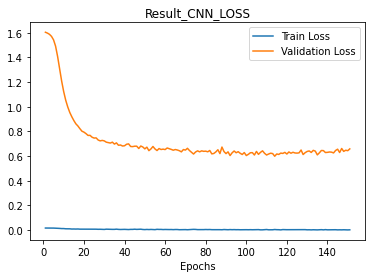

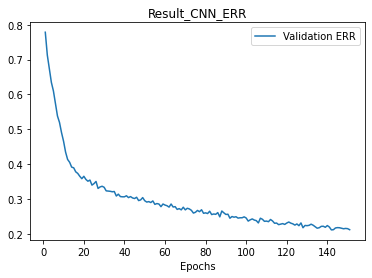

<Figure size 432x288 with 0 Axes>

In [13]:
print("Training start")

train_loss_list=[]
val_loss_list=[]

x_step=[]
y_err=[]

for epoch in range(num_epochs+1):
  for i, train_data in enumerate(train_loader):

    tain_loss = 0.0

    train_accent, train_label = train_data
  
    train_accent=train_accent.to(device)
    train_label=train_label.to(device)
    
    optimizer.zero_grad()

    hypothesis = cnn_model(train_accent).to(device)
    trn_loss = criterion(hypothesis, train_label)

    trn_loss.backward()
    optimizer.step()

    tain_loss+=trn_loss

    with torch.no_grad():

      val_loss=0.0
      correct = 0
      total = 0

      for j,val_data in enumerate(val_loader):
        val_accent, val_label = val_data
      
        val_accent=val_accent.to(device)
        val_label=val_label.to(device)

        prediction = cnn_model(val_accent)
        vl_loss = criterion(prediction, val_label)
  
        _, predicted = torch.max(prediction.data, 1)

        val_loss+=vl_loss*len(val_label)
        total += val_label.size(0)
        correct += (predicted == val_label).sum()
  
    correct = int(correct)
    total = int(total)

  if epoch % 10==0:
    print('Epoch: {:4d}/{} | Train loss: {:.6f}'.format(epoch, num_epochs, tain_loss / 100))
    print("Epoch: {:4d}/{} | Validation loss: {:.6f}".format(epoch, num_epochs, val_loss / total))
    print('[Validation set] ERR: %f | ACC: %f (%d / %d)' % (1 - (correct / total), correct / total, correct, total))
    print()
        
  train_loss_list.append(tain_loss/100)
  val_loss_list.append(val_loss/total)
  train_loss = 0.0

  x_step.append(epoch+1)
  y_err.append(1 - (correct / total))

plt.plot(x_step, train_loss_list, label = "Train Loss")
plt.plot(x_step, val_loss_list, label = "Validation Loss")
plt.xlabel('Epochs')
plt.title('Result_CNN_LOSS')
plt.legend()
plt.savefig('Result_CNN_LOSS.png')
plt.show()
plt.clf()

plt.plot(x_step, y_err, label = "Validation ERR")
plt.xlabel('Epochs')
plt.title('Result_CNN_ERR')
plt.legend()
plt.savefig('Result_CNN_ERR.png')
plt.show()
plt.clf()

In [14]:
print("Test start")

test_correct = 0
test_total = 0

with torch.no_grad():
    for k,test_data in enumerate(test_loader):
        test_accent, test_label = test_data

        test_accent=test_accent.to(device)
        test_label=test_label.to(device)

        test_prediction = cnn_model(test_accent)

        _, test_predicted = torch.max(test_prediction.data, 1)

        test_total += test_label.size(0)
        test_correct += (test_predicted == test_label).sum()

        test_correct = int(test_correct)
        test_total = int(test_total)

print('Accuracy of the model on the testset: %d %%' % (100 * test_correct / test_total))

Test start
Accuracy of the model on the testset: 80 %
